In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Sepulveda2020_value_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 629ms/step - loss: 59596.3438
Epoch 2/3500
1/1 [==============================] - 0s 4ms/step - loss: 59305.1719
Epoch 3/3500
1/1 [==============================] - 0s 4ms/step - loss: 59108.1797
Epoch 4/3500
1/1 [==============================] - 0s 4ms/step - loss: 58946.4570
Epoch 5/3500
1/1 [==============================] - 0s 4ms/step - loss: 58803.8906
Epoch 6/3500
1/1 [==============================] - 0s 5ms/step - loss: 58673.4922
Epoch 7/3500
1/1 [==============================] - 0s 4ms/step - loss: 58551.5000
Epoch 8/3500
1/1 [==============================] - 0s 4ms/step - loss: 58435.6250
Epoch 9/3500
1/1 [==============================] - 0s 4ms/step - loss: 58324.4141
Epoch 10/3500
1/1 [==============================] - 0s 4ms/step - loss: 58216.8750
Epoch 11/3500
1/1 [==============================] - 0s 4ms/step - loss: 58112.3125
Epoch 12/3500
1/1 [==============================] - 0s 4ms/step - loss: 58010.1680

1/1 [==============================] - 0s 5ms/step - loss: 50738.2969
Epoch 99/3500
1/1 [==============================] - 0s 4ms/step - loss: 50678.2422
Epoch 100/3500
1/1 [==============================] - 0s 4ms/step - loss: 50618.8125
Epoch 101/3500
1/1 [==============================] - 0s 4ms/step - loss: 50559.9922
Epoch 102/3500
1/1 [==============================] - 0s 5ms/step - loss: 50501.7812
Epoch 103/3500
1/1 [==============================] - 0s 4ms/step - loss: 50444.1562
Epoch 104/3500
1/1 [==============================] - 0s 4ms/step - loss: 50387.1211
Epoch 105/3500
1/1 [==============================] - 0s 5ms/step - loss: 50330.6562
Epoch 106/3500
1/1 [==============================] - 0s 4ms/step - loss: 50274.7695
Epoch 107/3500
1/1 [==============================] - 0s 4ms/step - loss: 50219.4453
Epoch 108/3500
1/1 [==============================] - 0s 4ms/step - loss: 50164.6680
Epoch 109/3500
1/1 [==============================] - 0s 4ms/step - loss: 50110.4

1/1 [==============================] - 0s 4ms/step - loss: 46833.3516
Epoch 195/3500
1/1 [==============================] - 0s 4ms/step - loss: 46805.0000
Epoch 196/3500
1/1 [==============================] - 0s 4ms/step - loss: 46776.8047
Epoch 197/3500
1/1 [==============================] - 0s 3ms/step - loss: 46748.7500
Epoch 198/3500
1/1 [==============================] - 0s 4ms/step - loss: 46720.8438
Epoch 199/3500
1/1 [==============================] - 0s 4ms/step - loss: 46693.0820
Epoch 200/3500
1/1 [==============================] - 0s 4ms/step - loss: 46665.4688
Epoch 201/3500
1/1 [==============================] - 0s 4ms/step - loss: 46637.9844
Epoch 202/3500
1/1 [==============================] - 0s 4ms/step - loss: 46610.6484
Epoch 203/3500
1/1 [==============================] - 0s 4ms/step - loss: 46583.4453
Epoch 204/3500
1/1 [==============================] - 0s 4ms/step - loss: 46556.3750
Epoch 205/3500
1/1 [==============================] - 0s 4ms/step - loss: 46529.

1/1 [==============================] - 0s 4ms/step - loss: 44593.1055
Epoch 291/3500
1/1 [==============================] - 0s 4ms/step - loss: 44573.3281
Epoch 292/3500
1/1 [==============================] - 0s 4ms/step - loss: 44553.5938
Epoch 293/3500
1/1 [==============================] - 0s 4ms/step - loss: 44533.9219
Epoch 294/3500
1/1 [==============================] - 0s 4ms/step - loss: 44514.2891
Epoch 295/3500
1/1 [==============================] - 0s 4ms/step - loss: 44494.7031
Epoch 296/3500
1/1 [==============================] - 0s 4ms/step - loss: 44475.1719
Epoch 297/3500
1/1 [==============================] - 0s 4ms/step - loss: 44455.6836
Epoch 298/3500
1/1 [==============================] - 0s 4ms/step - loss: 44436.2500
Epoch 299/3500
1/1 [==============================] - 0s 3ms/step - loss: 44416.8594
Epoch 300/3500
1/1 [==============================] - 0s 4ms/step - loss: 44397.5078
Epoch 301/3500
1/1 [==============================] - 0s 4ms/step - loss: 44378.

1/1 [==============================] - 0s 4ms/step - loss: 42873.7500
Epoch 387/3500
1/1 [==============================] - 0s 4ms/step - loss: 42857.3516
Epoch 388/3500
1/1 [==============================] - 0s 4ms/step - loss: 42840.9766
Epoch 389/3500
1/1 [==============================] - 0s 4ms/step - loss: 42824.6328
Epoch 390/3500
1/1 [==============================] - 0s 4ms/step - loss: 42808.3125
Epoch 391/3500
1/1 [==============================] - 0s 4ms/step - loss: 42792.0156
Epoch 392/3500
1/1 [==============================] - 0s 4ms/step - loss: 42775.7422
Epoch 393/3500
1/1 [==============================] - 0s 3ms/step - loss: 42759.4922
Epoch 394/3500
1/1 [==============================] - 0s 4ms/step - loss: 42743.2695
Epoch 395/3500
1/1 [==============================] - 0s 4ms/step - loss: 42727.0664
Epoch 396/3500
1/1 [==============================] - 0s 3ms/step - loss: 42710.8906
Epoch 397/3500
1/1 [==============================] - 0s 4ms/step - loss: 42694.

1/1 [==============================] - 0s 5ms/step - loss: 41401.4102
Epoch 483/3500
1/1 [==============================] - 0s 5ms/step - loss: 41387.0312
Epoch 484/3500
1/1 [==============================] - 0s 4ms/step - loss: 41372.6562
Epoch 485/3500
1/1 [==============================] - 0s 5ms/step - loss: 41358.2773
Epoch 486/3500
1/1 [==============================] - 0s 5ms/step - loss: 41343.8672
Epoch 487/3500
1/1 [==============================] - 0s 5ms/step - loss: 41329.4141
Epoch 488/3500
1/1 [==============================] - 0s 5ms/step - loss: 41315.1133
Epoch 489/3500
1/1 [==============================] - 0s 4ms/step - loss: 41300.8594
Epoch 490/3500
1/1 [==============================] - 0s 5ms/step - loss: 41286.5195
Epoch 491/3500
1/1 [==============================] - 0s 5ms/step - loss: 41272.2500
Epoch 492/3500
1/1 [==============================] - 0s 4ms/step - loss: 41258.0156
Epoch 493/3500
1/1 [==============================] - 0s 5ms/step - loss: 41243.

1/1 [==============================] - 0s 4ms/step - loss: 39895.7344
Epoch 579/3500
1/1 [==============================] - 0s 4ms/step - loss: 39878.7109
Epoch 580/3500
1/1 [==============================] - 0s 4ms/step - loss: 39861.7344
Epoch 581/3500
1/1 [==============================] - 0s 4ms/step - loss: 39844.7930
Epoch 582/3500
1/1 [==============================] - 0s 3ms/step - loss: 39827.8906
Epoch 583/3500
1/1 [==============================] - 0s 4ms/step - loss: 39811.0273
Epoch 584/3500
1/1 [==============================] - 0s 4ms/step - loss: 39794.1992
Epoch 585/3500
1/1 [==============================] - 0s 4ms/step - loss: 39777.3945
Epoch 586/3500
1/1 [==============================] - 0s 4ms/step - loss: 39760.6172
Epoch 587/3500
1/1 [==============================] - 0s 4ms/step - loss: 39743.8672
Epoch 588/3500
1/1 [==============================] - 0s 4ms/step - loss: 39727.1406
Epoch 589/3500
1/1 [==============================] - 0s 4ms/step - loss: 39710.

1/1 [==============================] - 0s 3ms/step - loss: 38424.3438
Epoch 675/3500
1/1 [==============================] - 0s 4ms/step - loss: 38411.0625
Epoch 676/3500
1/1 [==============================] - 0s 4ms/step - loss: 38397.7891
Epoch 677/3500
1/1 [==============================] - 0s 3ms/step - loss: 38384.5586
Epoch 678/3500
1/1 [==============================] - 0s 3ms/step - loss: 38371.3438
Epoch 679/3500
1/1 [==============================] - 0s 3ms/step - loss: 38358.1875
Epoch 680/3500
1/1 [==============================] - 0s 3ms/step - loss: 38345.0312
Epoch 681/3500
1/1 [==============================] - 0s 3ms/step - loss: 38331.9375
Epoch 682/3500
1/1 [==============================] - 0s 3ms/step - loss: 38318.8594
Epoch 683/3500
1/1 [==============================] - 0s 3ms/step - loss: 38305.8359
Epoch 684/3500
1/1 [==============================] - 0s 3ms/step - loss: 38292.8164
Epoch 685/3500
1/1 [==============================] - 0s 4ms/step - loss: 38279.

1/1 [==============================] - 0s 5ms/step - loss: 37255.1875
Epoch 771/3500
1/1 [==============================] - 0s 4ms/step - loss: 37243.7891
Epoch 772/3500
1/1 [==============================] - 0s 4ms/step - loss: 37232.3711
Epoch 773/3500
1/1 [==============================] - 0s 5ms/step - loss: 37220.9883
Epoch 774/3500
1/1 [==============================] - 0s 4ms/step - loss: 37209.5859
Epoch 775/3500
1/1 [==============================] - 0s 4ms/step - loss: 37198.2305
Epoch 776/3500
1/1 [==============================] - 0s 5ms/step - loss: 37186.8438
Epoch 777/3500
1/1 [==============================] - 0s 5ms/step - loss: 37175.5156
Epoch 778/3500
1/1 [==============================] - 0s 4ms/step - loss: 37164.1445
Epoch 779/3500
1/1 [==============================] - 0s 4ms/step - loss: 37152.8359
Epoch 780/3500
1/1 [==============================] - 0s 4ms/step - loss: 37141.4961
Epoch 781/3500
1/1 [==============================] - 0s 4ms/step - loss: 37130.

1/1 [==============================] - 0s 3ms/step - loss: 36193.8047
Epoch 867/3500
1/1 [==============================] - 0s 3ms/step - loss: 36182.9375
Epoch 868/3500
1/1 [==============================] - 0s 3ms/step - loss: 36171.9688
Epoch 869/3500
1/1 [==============================] - 0s 3ms/step - loss: 36161.0820
Epoch 870/3500
1/1 [==============================] - 0s 3ms/step - loss: 36150.1016
Epoch 871/3500
1/1 [==============================] - 0s 3ms/step - loss: 36139.2070
Epoch 872/3500
1/1 [==============================] - 0s 3ms/step - loss: 36128.2109
Epoch 873/3500
1/1 [==============================] - 0s 3ms/step - loss: 36117.3047
Epoch 874/3500
1/1 [==============================] - 0s 3ms/step - loss: 36106.2930
Epoch 875/3500
1/1 [==============================] - 0s 3ms/step - loss: 36095.3672
Epoch 876/3500
1/1 [==============================] - 0s 3ms/step - loss: 36084.3359
Epoch 877/3500
1/1 [==============================] - 0s 3ms/step - loss: 36073.

1/1 [==============================] - 0s 4ms/step - loss: 34787.8906
Epoch 963/3500
1/1 [==============================] - 0s 10ms/step - loss: 34760.6406
Epoch 964/3500
1/1 [==============================] - 0s 6ms/step - loss: 34733.9531
Epoch 965/3500
1/1 [==============================] - 0s 4ms/step - loss: 34707.9922
Epoch 966/3500
1/1 [==============================] - 0s 4ms/step - loss: 34682.9219
Epoch 967/3500
1/1 [==============================] - 0s 4ms/step - loss: 34658.7656
Epoch 968/3500
1/1 [==============================] - 0s 12ms/step - loss: 34635.4805
Epoch 969/3500
1/1 [==============================] - 0s 5ms/step - loss: 34612.9375
Epoch 970/3500
1/1 [==============================] - 0s 4ms/step - loss: 34591.0000
Epoch 971/3500
1/1 [==============================] - 0s 4ms/step - loss: 34569.5156
Epoch 972/3500
1/1 [==============================] - 0s 4ms/step - loss: 34548.3203
Epoch 973/3500
1/1 [==============================] - 0s 5ms/step - loss: 3452

1/1 [==============================] - 0s 4ms/step - loss: 33099.4453
Epoch 1058/3500
1/1 [==============================] - 0s 4ms/step - loss: 33087.3359
Epoch 1059/3500
1/1 [==============================] - 0s 5ms/step - loss: 33075.5312
Epoch 1060/3500
1/1 [==============================] - 0s 4ms/step - loss: 33063.7891
Epoch 1061/3500
1/1 [==============================] - 0s 4ms/step - loss: 33052.2031
Epoch 1062/3500
1/1 [==============================] - 0s 4ms/step - loss: 33040.6719
Epoch 1063/3500
1/1 [==============================] - 0s 4ms/step - loss: 33029.3203
Epoch 1064/3500
1/1 [==============================] - 0s 5ms/step - loss: 33018.0195
Epoch 1065/3500
1/1 [==============================] - 0s 5ms/step - loss: 33007.0000
Epoch 1066/3500
1/1 [==============================] - 0s 5ms/step - loss: 32995.8750
Epoch 1067/3500
1/1 [==============================] - 0s 5ms/step - loss: 32985.0156
Epoch 1068/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 31448.9297
Epoch 1153/3500
1/1 [==============================] - 0s 4ms/step - loss: 31433.6641
Epoch 1154/3500
1/1 [==============================] - 0s 3ms/step - loss: 31418.8086
Epoch 1155/3500
1/1 [==============================] - 0s 4ms/step - loss: 31404.4219
Epoch 1156/3500
1/1 [==============================] - 0s 3ms/step - loss: 31390.3477
Epoch 1157/3500
1/1 [==============================] - 0s 4ms/step - loss: 31376.6660
Epoch 1158/3500
1/1 [==============================] - 0s 3ms/step - loss: 31363.1875
Epoch 1159/3500
1/1 [==============================] - 0s 4ms/step - loss: 31350.0273
Epoch 1160/3500
1/1 [==============================] - 0s 4ms/step - loss: 31337.0000
Epoch 1161/3500
1/1 [==============================] - 0s 3ms/step - loss: 31324.2578
Epoch 1162/3500
1/1 [==============================] - 0s 3ms/step - loss: 31311.6172
Epoch 1163/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 30480.9023
Epoch 1248/3500
1/1 [==============================] - 0s 3ms/step - loss: 30472.6895
Epoch 1249/3500
1/1 [==============================] - 0s 3ms/step - loss: 30464.6055
Epoch 1250/3500
1/1 [==============================] - 0s 3ms/step - loss: 30456.4531
Epoch 1251/3500
1/1 [==============================] - 0s 3ms/step - loss: 30448.4258
Epoch 1252/3500
1/1 [==============================] - 0s 4ms/step - loss: 30440.3320
Epoch 1253/3500
1/1 [==============================] - 0s 4ms/step - loss: 30432.3613
Epoch 1254/3500
1/1 [==============================] - 0s 4ms/step - loss: 30424.3242
Epoch 1255/3500
1/1 [==============================] - 0s 3ms/step - loss: 30416.4141
Epoch 1256/3500
1/1 [==============================] - 0s 3ms/step - loss: 30408.4316
Epoch 1257/3500
1/1 [==============================] - 0s 3ms/step - loss: 30400.5742
Epoch 1258/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29807.6758
Epoch 1343/3500
1/1 [==============================] - 0s 5ms/step - loss: 29801.5352
Epoch 1344/3500
1/1 [==============================] - 0s 5ms/step - loss: 29795.2617
Epoch 1345/3500
1/1 [==============================] - 0s 5ms/step - loss: 29789.1680
Epoch 1346/3500
1/1 [==============================] - 0s 5ms/step - loss: 29782.9102
Epoch 1347/3500
1/1 [==============================] - 0s 5ms/step - loss: 29776.8359
Epoch 1348/3500
1/1 [==============================] - 0s 5ms/step - loss: 29770.5918
Epoch 1349/3500
1/1 [==============================] - 0s 6ms/step - loss: 29764.5352
Epoch 1350/3500
1/1 [==============================] - 0s 5ms/step - loss: 29758.3203
Epoch 1351/3500
1/1 [==============================] - 0s 4ms/step - loss: 29752.3027
Epoch 1352/3500
1/1 [==============================] - 0s 4ms/step - loss: 29746.1484
Epoch 1353/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 29279.7012
Epoch 1438/3500
1/1 [==============================] - 0s 4ms/step - loss: 29274.7324
Epoch 1439/3500
1/1 [==============================] - 0s 4ms/step - loss: 29269.9902
Epoch 1440/3500
1/1 [==============================] - 0s 4ms/step - loss: 29265.0430
Epoch 1441/3500
1/1 [==============================] - 0s 4ms/step - loss: 29260.2109
Epoch 1442/3500
1/1 [==============================] - 0s 4ms/step - loss: 29255.1738
Epoch 1443/3500
1/1 [==============================] - 0s 4ms/step - loss: 29250.3105
Epoch 1444/3500
1/1 [==============================] - 0s 4ms/step - loss: 29245.2969
Epoch 1445/3500
1/1 [==============================] - 0s 4ms/step - loss: 29240.5430
Epoch 1446/3500
1/1 [==============================] - 0s 4ms/step - loss: 29235.6016
Epoch 1447/3500
1/1 [==============================] - 0s 4ms/step - loss: 29230.9512
Epoch 1448/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 28851.1992
Epoch 1533/3500
1/1 [==============================] - 0s 5ms/step - loss: 28847.7773
Epoch 1534/3500
1/1 [==============================] - 0s 5ms/step - loss: 28843.6836
Epoch 1535/3500
1/1 [==============================] - 0s 5ms/step - loss: 28839.9688
Epoch 1536/3500
1/1 [==============================] - 0s 5ms/step - loss: 28835.4531
Epoch 1537/3500
1/1 [==============================] - 0s 5ms/step - loss: 28831.5078
Epoch 1538/3500
1/1 [==============================] - 0s 5ms/step - loss: 28827.1680
Epoch 1539/3500
1/1 [==============================] - 0s 5ms/step - loss: 28823.4414
Epoch 1540/3500
1/1 [==============================] - 0s 5ms/step - loss: 28819.4922
Epoch 1541/3500
1/1 [==============================] - 0s 5ms/step - loss: 28816.1055
Epoch 1542/3500
1/1 [==============================] - 0s 6ms/step - loss: 28812.4414
Epoch 1543/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 28521.8008
Epoch 1628/3500
1/1 [==============================] - 0s 4ms/step - loss: 28518.0273
Epoch 1629/3500
1/1 [==============================] - 0s 4ms/step - loss: 28515.2070
Epoch 1630/3500
1/1 [==============================] - 0s 4ms/step - loss: 28512.0938
Epoch 1631/3500
1/1 [==============================] - 0s 4ms/step - loss: 28509.6152
Epoch 1632/3500
1/1 [==============================] - 0s 4ms/step - loss: 28506.7500
Epoch 1633/3500
1/1 [==============================] - 0s 4ms/step - loss: 28504.1973
Epoch 1634/3500
1/1 [==============================] - 0s 4ms/step - loss: 28501.0664
Epoch 1635/3500
1/1 [==============================] - 0s 4ms/step - loss: 28498.0312
Epoch 1636/3500
1/1 [==============================] - 0s 4ms/step - loss: 28494.5078
Epoch 1637/3500
1/1 [==============================] - 0s 4ms/step - loss: 28491.4102
Epoch 1638/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 28262.6758
Epoch 1723/3500
1/1 [==============================] - 0s 6ms/step - loss: 28260.2832
Epoch 1724/3500
1/1 [==============================] - 0s 5ms/step - loss: 28257.3184
Epoch 1725/3500
1/1 [==============================] - 0s 5ms/step - loss: 28254.7812
Epoch 1726/3500
1/1 [==============================] - 0s 5ms/step - loss: 28251.8789
Epoch 1727/3500
1/1 [==============================] - 0s 5ms/step - loss: 28249.6680
Epoch 1728/3500
1/1 [==============================] - 0s 8ms/step - loss: 28247.1094
Epoch 1729/3500
1/1 [==============================] - 0s 8ms/step - loss: 28245.4961
Epoch 1730/3500
1/1 [==============================] - 0s 6ms/step - loss: 28243.1113
Epoch 1731/3500
1/1 [==============================] - 0s 6ms/step - loss: 28241.3828
Epoch 1732/3500
1/1 [==============================] - 0s 6ms/step - loss: 28238.0820
Epoch 1733/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 28050.7578
Epoch 1818/3500
1/1 [==============================] - 0s 4ms/step - loss: 28047.6172
Epoch 1819/3500
1/1 [==============================] - 0s 3ms/step - loss: 28045.5293
Epoch 1820/3500
1/1 [==============================] - 0s 3ms/step - loss: 28042.7695
Epoch 1821/3500
1/1 [==============================] - 0s 4ms/step - loss: 28041.1289
Epoch 1822/3500
1/1 [==============================] - 0s 4ms/step - loss: 28039.0977
Epoch 1823/3500
1/1 [==============================] - 0s 3ms/step - loss: 28037.7930
Epoch 1824/3500
1/1 [==============================] - 0s 3ms/step - loss: 28035.7773
Epoch 1825/3500
1/1 [==============================] - 0s 3ms/step - loss: 28034.1406
Epoch 1826/3500
1/1 [==============================] - 0s 4ms/step - loss: 28031.5723
Epoch 1827/3500
1/1 [==============================] - 0s 5ms/step - loss: 28029.5781
Epoch 1828/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27872.4492
Epoch 1913/3500
1/1 [==============================] - 0s 3ms/step - loss: 27870.9551
Epoch 1914/3500
1/1 [==============================] - 0s 3ms/step - loss: 27869.1484
Epoch 1915/3500
1/1 [==============================] - 0s 3ms/step - loss: 27868.4727
Epoch 1916/3500
1/1 [==============================] - 0s 3ms/step - loss: 27866.6523
Epoch 1917/3500
1/1 [==============================] - 0s 3ms/step - loss: 27865.8027
Epoch 1918/3500
1/1 [==============================] - 0s 4ms/step - loss: 27863.2773
Epoch 1919/3500
1/1 [==============================] - 0s 4ms/step - loss: 27861.5879
Epoch 1920/3500
1/1 [==============================] - 0s 3ms/step - loss: 27858.9883
Epoch 1921/3500
1/1 [==============================] - 0s 3ms/step - loss: 27857.4922
Epoch 1922/3500
1/1 [==============================] - 0s 3ms/step - loss: 27855.7812
Epoch 1923/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27726.8359
Epoch 2008/3500
1/1 [==============================] - 0s 3ms/step - loss: 27725.0840
Epoch 2009/3500
1/1 [==============================] - 0s 3ms/step - loss: 27723.9375
Epoch 2010/3500
1/1 [==============================] - 0s 3ms/step - loss: 27721.6348
Epoch 2011/3500
1/1 [==============================] - 0s 3ms/step - loss: 27720.1445
Epoch 2012/3500
1/1 [==============================] - 0s 3ms/step - loss: 27718.0527
Epoch 2013/3500
1/1 [==============================] - 0s 3ms/step - loss: 27716.9512
Epoch 2014/3500
1/1 [==============================] - 0s 3ms/step - loss: 27715.8105
Epoch 2015/3500
1/1 [==============================] - 0s 3ms/step - loss: 27715.5117
Epoch 2016/3500
1/1 [==============================] - 0s 3ms/step - loss: 27714.1230
Epoch 2017/3500
1/1 [==============================] - 0s 3ms/step - loss: 27713.2305
Epoch 2018/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27602.9336
Epoch 2103/3500
1/1 [==============================] - 0s 3ms/step - loss: 27601.4102
Epoch 2104/3500
1/1 [==============================] - 0s 3ms/step - loss: 27599.2910
Epoch 2105/3500
1/1 [==============================] - 0s 3ms/step - loss: 27598.3281
Epoch 2106/3500
1/1 [==============================] - 0s 3ms/step - loss: 27597.1934
Epoch 2107/3500
1/1 [==============================] - 0s 3ms/step - loss: 27596.9512
Epoch 2108/3500
1/1 [==============================] - 0s 3ms/step - loss: 27595.8652
Epoch 2109/3500
1/1 [==============================] - 0s 4ms/step - loss: 27595.0879
Epoch 2110/3500
1/1 [==============================] - 0s 3ms/step - loss: 27593.1484
Epoch 2111/3500
1/1 [==============================] - 0s 3ms/step - loss: 27591.7363
Epoch 2112/3500
1/1 [==============================] - 0s 3ms/step - loss: 27589.7344
Epoch 2113/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27498.1328
Epoch 2198/3500
1/1 [==============================] - 0s 3ms/step - loss: 27496.1973
Epoch 2199/3500
1/1 [==============================] - 0s 3ms/step - loss: 27495.4219
Epoch 2200/3500
1/1 [==============================] - 0s 3ms/step - loss: 27493.8359
Epoch 2201/3500
1/1 [==============================] - 0s 3ms/step - loss: 27493.8066
Epoch 2202/3500
1/1 [==============================] - 0s 3ms/step - loss: 27493.5156
Epoch 2203/3500
1/1 [==============================] - 0s 3ms/step - loss: 27494.1504
Epoch 2204/3500
1/1 [==============================] - 0s 3ms/step - loss: 27492.3691
Epoch 2205/3500
1/1 [==============================] - 0s 3ms/step - loss: 27491.3086
Epoch 2206/3500
1/1 [==============================] - 0s 3ms/step - loss: 27488.6953
Epoch 2207/3500
1/1 [==============================] - 0s 4ms/step - loss: 27487.4277
Epoch 2208/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27412.0293
Epoch 2293/3500
1/1 [==============================] - 0s 3ms/step - loss: 27411.0195
Epoch 2294/3500
1/1 [==============================] - 0s 6ms/step - loss: 27408.1953
Epoch 2295/3500
1/1 [==============================] - 0s 4ms/step - loss: 27406.8730
Epoch 2296/3500
1/1 [==============================] - 0s 4ms/step - loss: 27405.3398
Epoch 2297/3500
1/1 [==============================] - 0s 4ms/step - loss: 27405.1543
Epoch 2298/3500
1/1 [==============================] - 0s 4ms/step - loss: 27404.6914
Epoch 2299/3500
1/1 [==============================] - 0s 4ms/step - loss: 27405.0352
Epoch 2300/3500
1/1 [==============================] - 0s 4ms/step - loss: 27404.7246
Epoch 2301/3500
1/1 [==============================] - 0s 4ms/step - loss: 27404.1055
Epoch 2302/3500
1/1 [==============================] - 0s 4ms/step - loss: 27402.2305
Epoch 2303/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27334.1953
Epoch 2388/3500
1/1 [==============================] - 0s 4ms/step - loss: 27333.2344
Epoch 2389/3500
1/1 [==============================] - 0s 4ms/step - loss: 27333.6055
Epoch 2390/3500
1/1 [==============================] - 0s 4ms/step - loss: 27333.6758
Epoch 2391/3500
1/1 [==============================] - 0s 4ms/step - loss: 27334.3535
Epoch 2392/3500
1/1 [==============================] - 0s 4ms/step - loss: 27333.4531
Epoch 2393/3500
1/1 [==============================] - 0s 5ms/step - loss: 27332.3984
Epoch 2394/3500
1/1 [==============================] - 0s 5ms/step - loss: 27330.5723
Epoch 2395/3500
1/1 [==============================] - 0s 4ms/step - loss: 27329.2891
Epoch 2396/3500
1/1 [==============================] - 0s 5ms/step - loss: 27327.7773
Epoch 2397/3500
1/1 [==============================] - 0s 5ms/step - loss: 27327.1621
Epoch 2398/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27269.6992
Epoch 2483/3500
1/1 [==============================] - 0s 3ms/step - loss: 27270.3984
Epoch 2484/3500
1/1 [==============================] - 0s 3ms/step - loss: 27270.7793
Epoch 2485/3500
1/1 [==============================] - 0s 3ms/step - loss: 27271.7500
Epoch 2486/3500
1/1 [==============================] - 0s 4ms/step - loss: 27271.1328
Epoch 2487/3500
1/1 [==============================] - 0s 3ms/step - loss: 27270.1699
Epoch 2488/3500
1/1 [==============================] - 0s 3ms/step - loss: 27268.0332
Epoch 2489/3500
1/1 [==============================] - 0s 3ms/step - loss: 27266.5195
Epoch 2490/3500
1/1 [==============================] - 0s 4ms/step - loss: 27265.0156
Epoch 2491/3500
1/1 [==============================] - 0s 3ms/step - loss: 27264.3867
Epoch 2492/3500
1/1 [==============================] - 0s 4ms/step - loss: 27263.7598
Epoch 2493/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 27214.9961
Epoch 2578/3500
1/1 [==============================] - 0s 3ms/step - loss: 27213.5566
Epoch 2579/3500
1/1 [==============================] - 0s 3ms/step - loss: 27213.1289
Epoch 2580/3500
1/1 [==============================] - 0s 3ms/step - loss: 27213.1504
Epoch 2581/3500
1/1 [==============================] - 0s 3ms/step - loss: 27214.2344
Epoch 2582/3500
1/1 [==============================] - 0s 3ms/step - loss: 27214.7793
Epoch 2583/3500
1/1 [==============================] - 0s 3ms/step - loss: 27215.6836
Epoch 2584/3500
1/1 [==============================] - 0s 3ms/step - loss: 27214.6914
Epoch 2585/3500
1/1 [==============================] - 0s 3ms/step - loss: 27213.1074
Epoch 2586/3500
1/1 [==============================] - 0s 3ms/step - loss: 27210.6797
Epoch 2587/3500
1/1 [==============================] - 0s 3ms/step - loss: 27209.3965
Epoch 2588/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27168.8555
Epoch 2673/3500
1/1 [==============================] - 0s 4ms/step - loss: 27170.1250
Epoch 2674/3500
1/1 [==============================] - 0s 4ms/step - loss: 27169.4727
Epoch 2675/3500
1/1 [==============================] - 0s 4ms/step - loss: 27168.6738
Epoch 2676/3500
1/1 [==============================] - 0s 4ms/step - loss: 27166.0762
Epoch 2677/3500
1/1 [==============================] - 0s 4ms/step - loss: 27164.5430
Epoch 2678/3500
1/1 [==============================] - 0s 4ms/step - loss: 27163.2090
Epoch 2679/3500
1/1 [==============================] - 0s 4ms/step - loss: 27162.7500
Epoch 2680/3500
1/1 [==============================] - 0s 4ms/step - loss: 27162.5176
Epoch 2681/3500
1/1 [==============================] - 0s 4ms/step - loss: 27163.4922
Epoch 2682/3500
1/1 [==============================] - 0s 4ms/step - loss: 27164.4844
Epoch 2683/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27128.2148
Epoch 2768/3500
1/1 [==============================] - 0s 5ms/step - loss: 27125.3438
Epoch 2769/3500
1/1 [==============================] - 0s 4ms/step - loss: 27123.7734
Epoch 2770/3500
1/1 [==============================] - 0s 4ms/step - loss: 27122.6855
Epoch 2771/3500
1/1 [==============================] - 0s 5ms/step - loss: 27122.5859
Epoch 2772/3500
1/1 [==============================] - 0s 5ms/step - loss: 27122.8281
Epoch 2773/3500
1/1 [==============================] - 0s 4ms/step - loss: 27124.0586
Epoch 2774/3500
1/1 [==============================] - 0s 5ms/step - loss: 27124.5820
Epoch 2775/3500
1/1 [==============================] - 0s 5ms/step - loss: 27125.6289
Epoch 2776/3500
1/1 [==============================] - 0s 4ms/step - loss: 27124.7070
Epoch 2777/3500
1/1 [==============================] - 0s 7ms/step - loss: 27123.8125
Epoch 2778/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27088.2949
Epoch 2863/3500
1/1 [==============================] - 0s 4ms/step - loss: 27087.9395
Epoch 2864/3500
1/1 [==============================] - 0s 4ms/step - loss: 27087.8945
Epoch 2865/3500
1/1 [==============================] - 0s 4ms/step - loss: 27089.1172
Epoch 2866/3500
1/1 [==============================] - 0s 4ms/step - loss: 27090.8574
Epoch 2867/3500
1/1 [==============================] - 0s 4ms/step - loss: 27093.5273
Epoch 2868/3500
1/1 [==============================] - 0s 4ms/step - loss: 27094.0469
Epoch 2869/3500
1/1 [==============================] - 0s 5ms/step - loss: 27091.2227
Epoch 2870/3500
1/1 [==============================] - 0s 4ms/step - loss: 27087.8418
Epoch 2871/3500
1/1 [==============================] - 0s 4ms/step - loss: 27085.8184
Epoch 2872/3500
1/1 [==============================] - 0s 4ms/step - loss: 27084.3867
Epoch 2873/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27059.7148
Epoch 2958/3500
1/1 [==============================] - 0s 4ms/step - loss: 27060.4531
Epoch 2959/3500
1/1 [==============================] - 0s 4ms/step - loss: 27061.2520
Epoch 2960/3500
1/1 [==============================] - 0s 58ms/step - loss: 27059.9414
Epoch 2961/3500
1/1 [==============================] - 0s 8ms/step - loss: 27059.4219
Epoch 2962/3500
1/1 [==============================] - 0s 5ms/step - loss: 27057.6289
Epoch 2963/3500
1/1 [==============================] - 0s 5ms/step - loss: 27056.8711
Epoch 2964/3500
1/1 [==============================] - 0s 5ms/step - loss: 27055.4102
Epoch 2965/3500
1/1 [==============================] - 0s 4ms/step - loss: 27055.3574
Epoch 2966/3500
1/1 [==============================] - 0s 5ms/step - loss: 27055.5508
Epoch 2967/3500
1/1 [==============================] - 0s 7ms/step - loss: 27056.3828
Epoch 2968/3500
1/1 [==============================] - 0s 7ms/step - 

1/1 [==============================] - 0s 3ms/step - loss: 27036.0625
Epoch 3053/3500
1/1 [==============================] - 0s 3ms/step - loss: 27032.7461
Epoch 3054/3500
1/1 [==============================] - 0s 4ms/step - loss: 27030.9336
Epoch 3055/3500
1/1 [==============================] - 0s 4ms/step - loss: 27030.8145
Epoch 3056/3500
1/1 [==============================] - 0s 4ms/step - loss: 27030.4961
Epoch 3057/3500
1/1 [==============================] - 0s 4ms/step - loss: 27031.1836
Epoch 3058/3500
1/1 [==============================] - 0s 5ms/step - loss: 27032.2539
Epoch 3059/3500
1/1 [==============================] - 0s 4ms/step - loss: 27032.9805
Epoch 3060/3500
1/1 [==============================] - 0s 4ms/step - loss: 27033.3594
Epoch 3061/3500
1/1 [==============================] - 0s 4ms/step - loss: 27033.3926
Epoch 3062/3500
1/1 [==============================] - 0s 4ms/step - loss: 27031.2168
Epoch 3063/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 27013.3828
Epoch 3148/3500
1/1 [==============================] - 0s 4ms/step - loss: 27016.3574
Epoch 3149/3500
1/1 [==============================] - 0s 4ms/step - loss: 27016.3867
Epoch 3150/3500
1/1 [==============================] - 0s 4ms/step - loss: 27014.1562
Epoch 3151/3500
1/1 [==============================] - 0s 4ms/step - loss: 27011.1465
Epoch 3152/3500
1/1 [==============================] - 0s 4ms/step - loss: 27008.8320
Epoch 3153/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.8301
Epoch 3154/3500
1/1 [==============================] - 0s 4ms/step - loss: 27007.5469
Epoch 3155/3500
1/1 [==============================] - 0s 3ms/step - loss: 27008.3594
Epoch 3156/3500
1/1 [==============================] - 0s 4ms/step - loss: 27008.8613
Epoch 3157/3500
1/1 [==============================] - 0s 4ms/step - loss: 27010.3887
Epoch 3158/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 26991.7227
Epoch 3243/3500
1/1 [==============================] - 0s 5ms/step - loss: 26994.6074
Epoch 3244/3500
1/1 [==============================] - 0s 5ms/step - loss: 26997.3438
Epoch 3245/3500
1/1 [==============================] - 0s 5ms/step - loss: 26996.8477
Epoch 3246/3500
1/1 [==============================] - 0s 6ms/step - loss: 26993.9062
Epoch 3247/3500
1/1 [==============================] - 0s 5ms/step - loss: 26990.9355
Epoch 3248/3500
1/1 [==============================] - 0s 5ms/step - loss: 26989.0254
Epoch 3249/3500
1/1 [==============================] - 0s 5ms/step - loss: 26989.1133
Epoch 3250/3500
1/1 [==============================] - 0s 5ms/step - loss: 26988.8281
Epoch 3251/3500
1/1 [==============================] - 0s 5ms/step - loss: 26989.4941
Epoch 3252/3500
1/1 [==============================] - 0s 5ms/step - loss: 26990.9062
Epoch 3253/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26973.3789
Epoch 3338/3500
1/1 [==============================] - 0s 4ms/step - loss: 26974.1641
Epoch 3339/3500
1/1 [==============================] - 0s 4ms/step - loss: 26976.4062
Epoch 3340/3500
1/1 [==============================] - 0s 4ms/step - loss: 26979.4707
Epoch 3341/3500
1/1 [==============================] - 0s 4ms/step - loss: 26981.1953
Epoch 3342/3500
1/1 [==============================] - 0s 4ms/step - loss: 26979.0000
Epoch 3343/3500
1/1 [==============================] - 0s 4ms/step - loss: 26975.8457
Epoch 3344/3500
1/1 [==============================] - 0s 4ms/step - loss: 26973.3594
Epoch 3345/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.1953
Epoch 3346/3500
1/1 [==============================] - 0s 4ms/step - loss: 26972.1406
Epoch 3347/3500
1/1 [==============================] - 0s 4ms/step - loss: 26973.5449
Epoch 3348/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 26963.3203
Epoch 3433/3500
1/1 [==============================] - 0s 4ms/step - loss: 26966.2227
Epoch 3434/3500
1/1 [==============================] - 0s 4ms/step - loss: 26965.6406
Epoch 3435/3500
1/1 [==============================] - 0s 4ms/step - loss: 26963.3828
Epoch 3436/3500
1/1 [==============================] - 0s 4ms/step - loss: 26960.0488
Epoch 3437/3500
1/1 [==============================] - 0s 4ms/step - loss: 26959.6133
Epoch 3438/3500
1/1 [==============================] - 0s 4ms/step - loss: 26958.5449
Epoch 3439/3500
1/1 [==============================] - 0s 4ms/step - loss: 26958.7617
Epoch 3440/3500
1/1 [==============================] - 0s 4ms/step - loss: 26959.6230
Epoch 3441/3500
1/1 [==============================] - 0s 4ms/step - loss: 26960.8887
Epoch 3442/3500
1/1 [==============================] - 0s 4ms/step - loss: 26962.8027
Epoch 3443/3500
1/1 [==============================] - 0s 4ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 501us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv.to_csv('Sp2020_value_complete.csv')

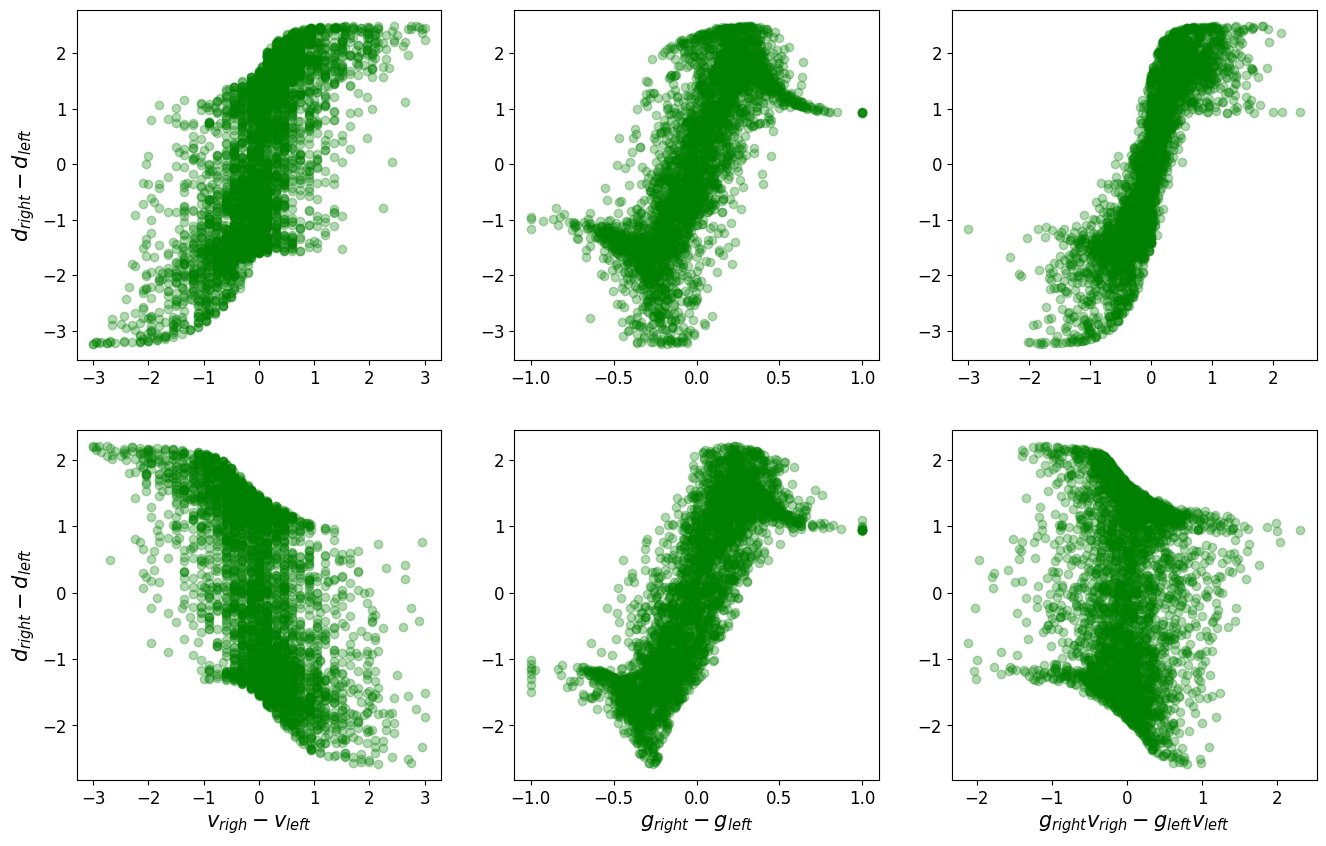

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');